# Anomaly Detection

# 1. Introduction

The main objective of this notebook is to detect anomalies or outliers using 3 different approaches:

* Interquartile Range (Statistic mean) Rango Intercuartil (medida estadística)
* K-Means Clustering
* Isolation Forest

As context, we use data from a water pump system with 52 sensors that collect information every minute. For reference, each sensor has more than 220.000 collected values (measurements).

# 2. Data loading and pre-processing

## 2.1 Sensor file loading



In [2]:
# Basic imports 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from sklearn.cluster import KMeans

In [3]:
# If used in Google Colab/Drive make sure to specify the correct path

drive.mount("/content/drive/", force_remount=True)

sst_home='drive/My Drive/Anomaly detection/'

Mounted at /content/drive/


In [4]:
# Load the file as a pandas dataframe

df = pd.read_csv(sst_home+'sensor.csv')
print(df.shape)
df.info()

(220320, 55)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 1

## 2.2 Data cleaning

- Removal of redundant and duplicated columns.
- Correction/treatment of invalid values and data types.


In [5]:
# Removal of column "sensor_15" since it only contains NaNs
del df['sensor_15']

# Removal of column "Unnamed: 0", since its the index and we already have 
# it on the dataframe
del df['Unnamed: 0'] 

# Removal of duplicated values
df = df.drop_duplicates()

In [6]:
# Quick function to calculate the amount of NaNs for each column
def calc_percent_NAs(df):
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df), columns=['percent']) 
    idx = nans['percent'] > 0
    return nans[idx]

calc_percent_NAs(df).head(10)

,percent
sensor_50,0.349569
sensor_51,0.069821
sensor_00,0.046333
sensor_07,0.024741
sensor_08,0.023180
sensor_06,0.021777
sensor_09,0.020856
sensor_01,0.001675
sensor_30,0.001185
sensor_29,0.000327


# 2.3 Invalid data analysis (NaN: Not a Number)

There is a significant amount of Nans in some columns, such as, sensor_50 which has 34%. In order to avoid this, we can fill these values with the mean of the column. This will not affect predictions since, we are not focusing on detecting sensor malfunction but rather value anomalies (water pump system anomalies).

In [7]:
# From this columns print, we can see the basic structure of our data.
# The first column, timestmap, refers to the time where each sensor took a value.
# The last column, machine_status, refers to the state of the water pump system 
# at each timestamp. All the other columns are values detected by sensors.
df.columns

Index(['timestamp', 'sensor_00', 'sensor_01', 'sensor_02', 'sensor_03',
       'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08',
       'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13',
       'sensor_14', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19',
       'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24',
       'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29',
       'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34',
       'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39',
       'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44',
       'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49',
       'sensor_50', 'sensor_51', 'machine_status'],
      dtype='object')

In [8]:
# As said before, we fill the missing values (NaN) with the mean of each column.
# Excluding machine_status and timestamp columns.
for name in df.columns:
  if name not in ['machine_status', 'timestamp']:
    df[name].fillna((df[name].mean()), inplace=True)

In [9]:
# To further confirm that there are no invalid values in our dataframe, the 
# following print should be empty
calc_percent_NAs(df).head(10)

,percent


# 2.4 Data pre-processing


## 2.4.1 DataFrame index change

Since one of the most important points of reference is the time of anomaly, we change our dataframe's index to timestamp instead of the basic numeric index.

In [10]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
# We can drop the column now that its the index.
if "timestamp" in df.columns:
  del df['timestamp']

In [11]:
df.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


## 2.4.2 Machine status identification

In [12]:
# Get the unique/different values that represent the state of the system at each 
# time
df["machine_status"].unique()

array(['NORMAL', 'BROKEN', 'RECOVERING'], dtype=object)

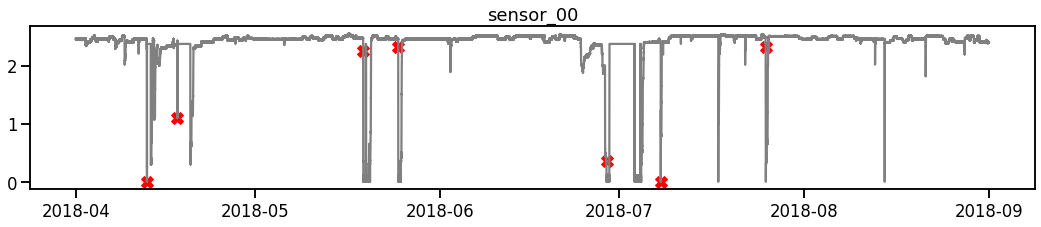

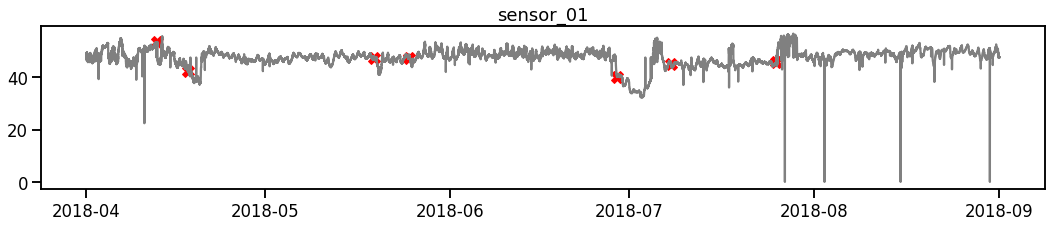

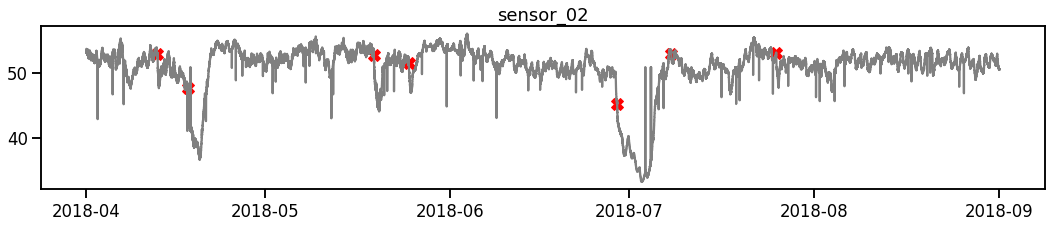

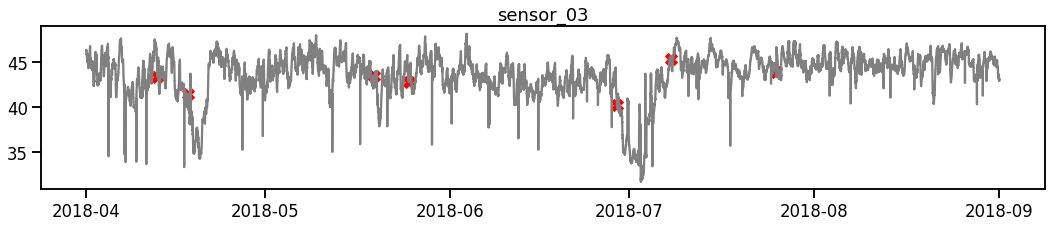

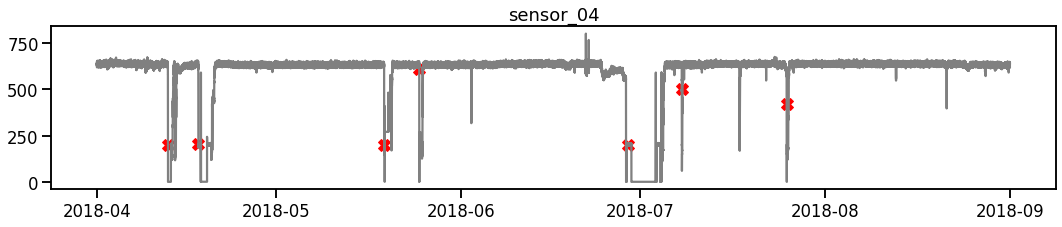

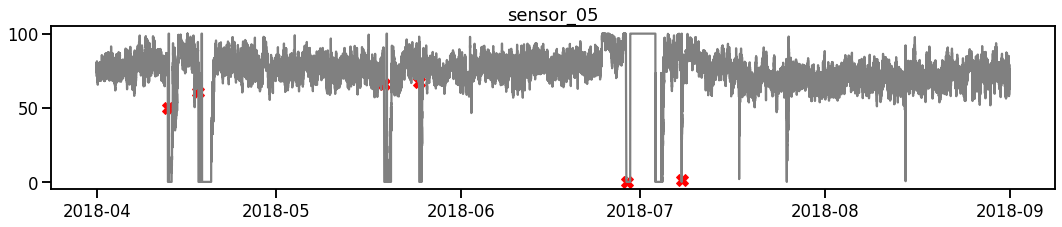

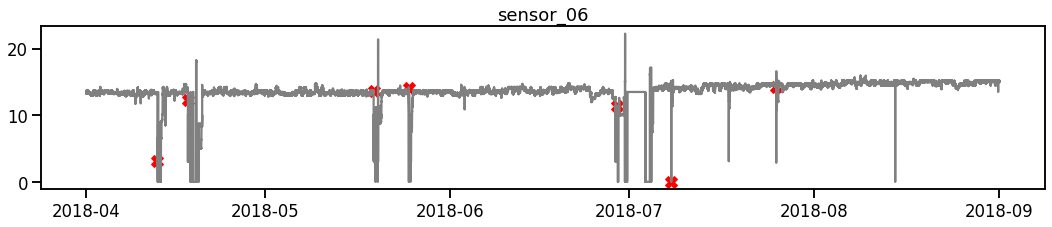

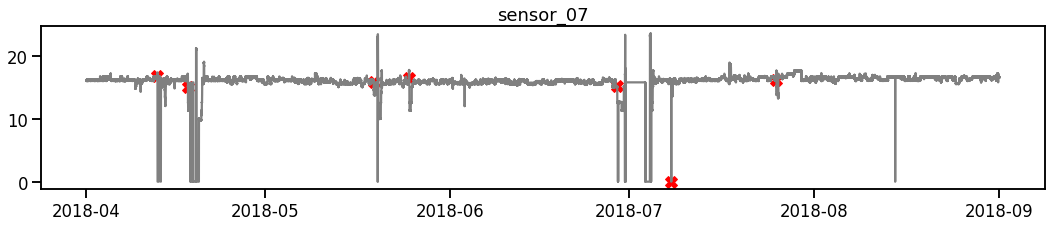

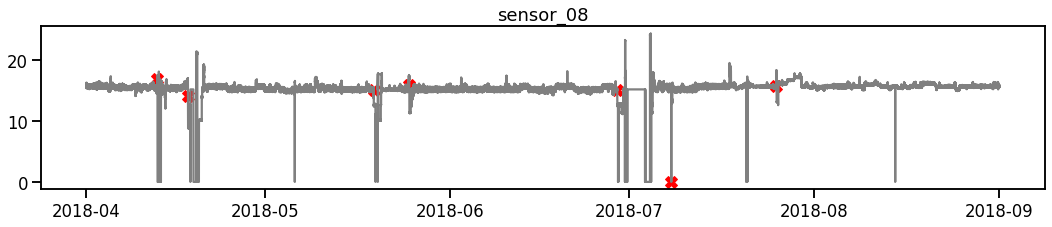

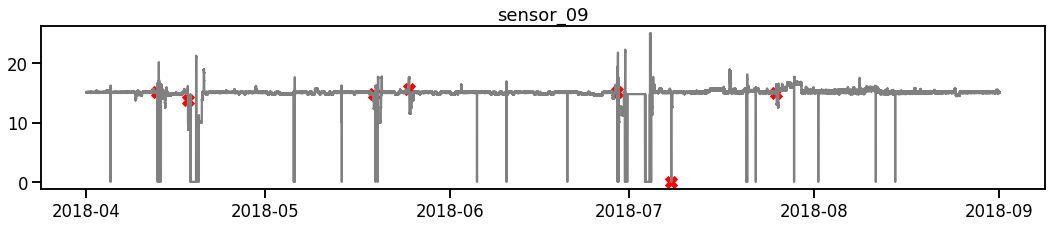

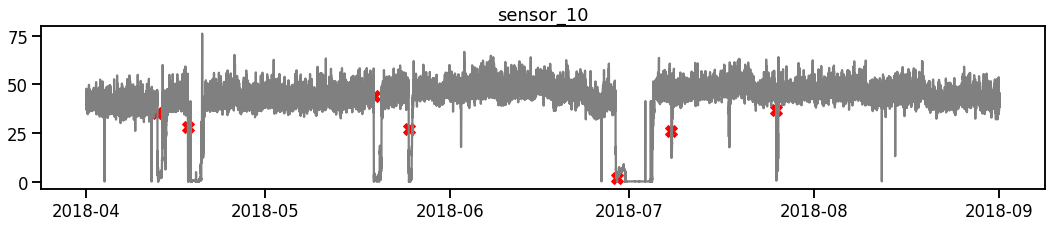

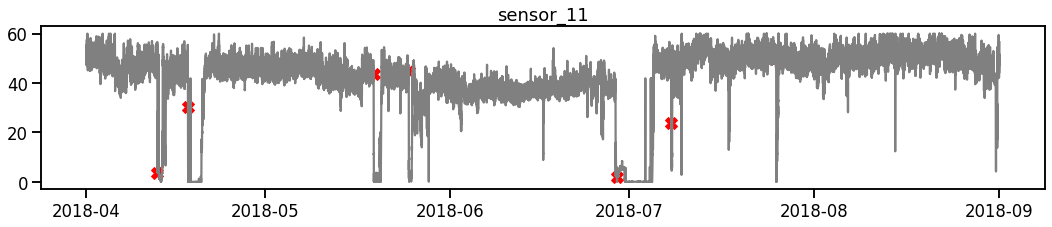

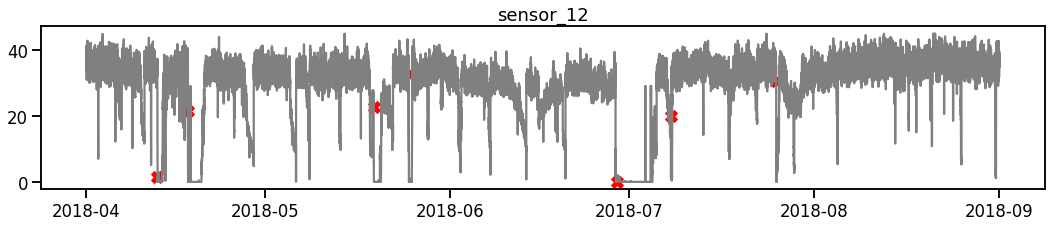

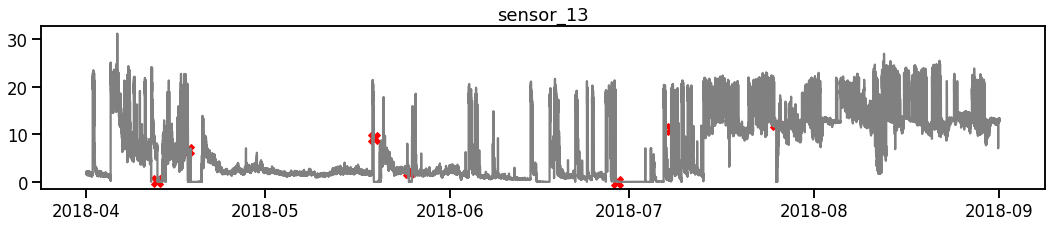

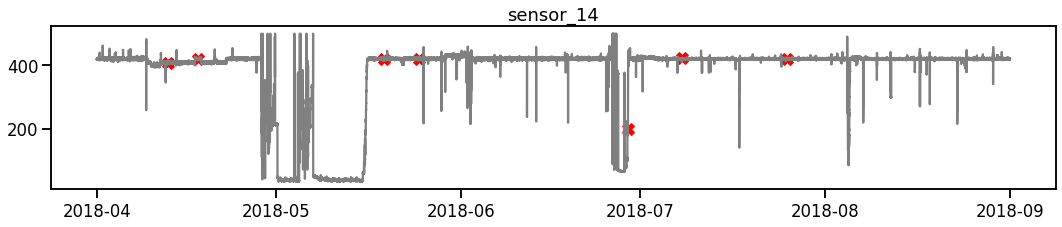

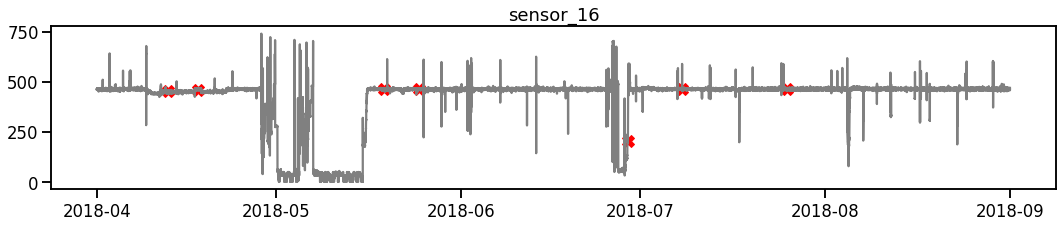

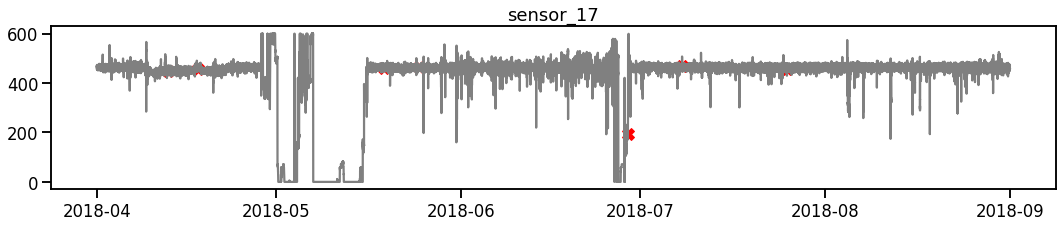

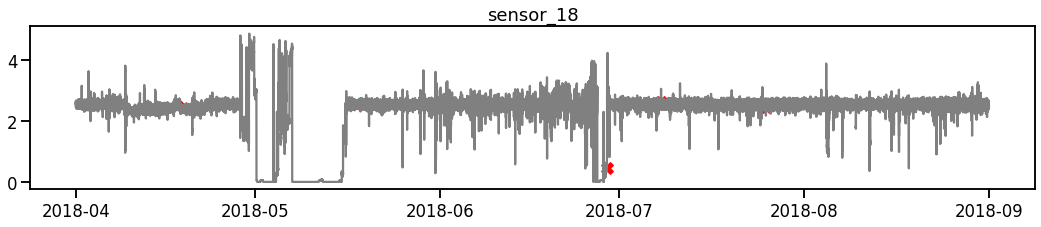

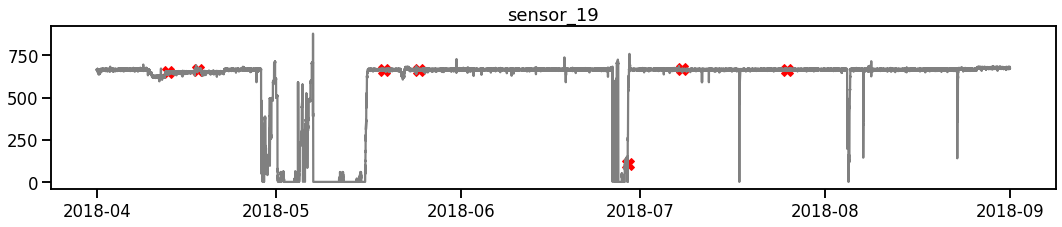

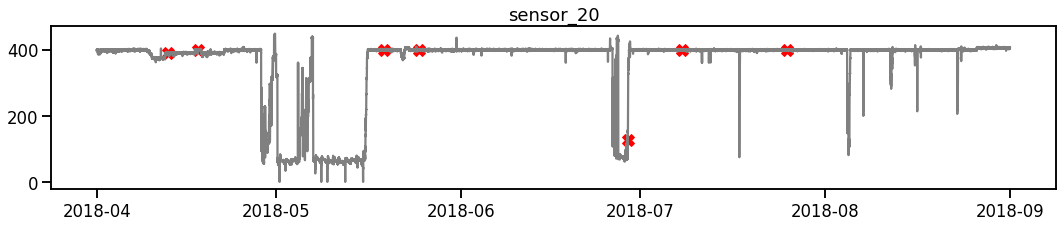

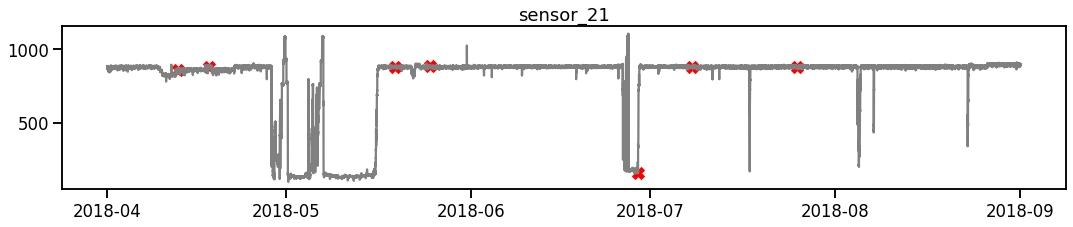

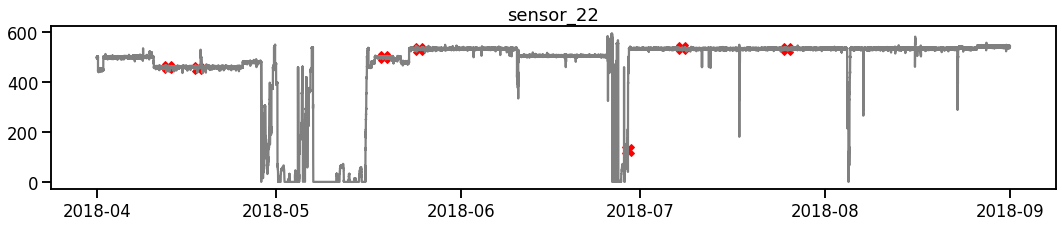

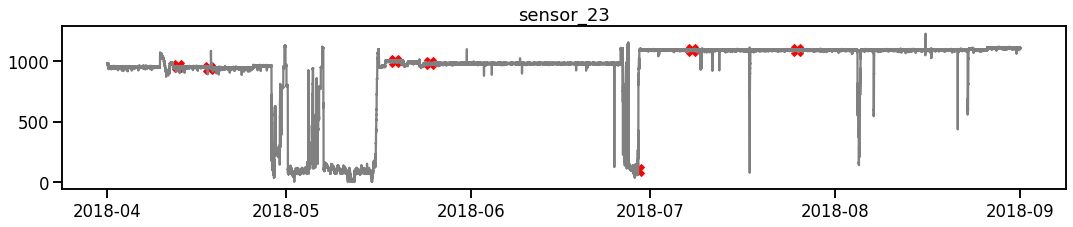

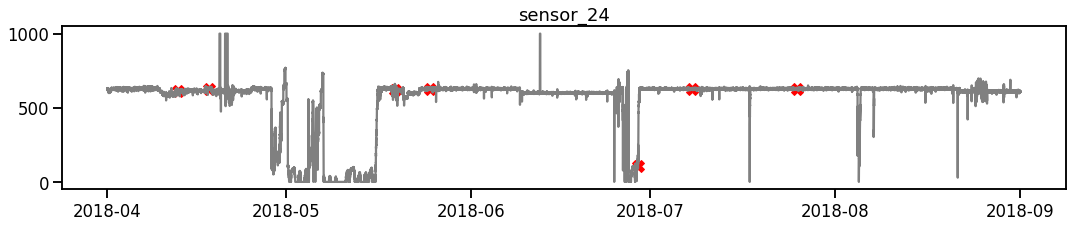

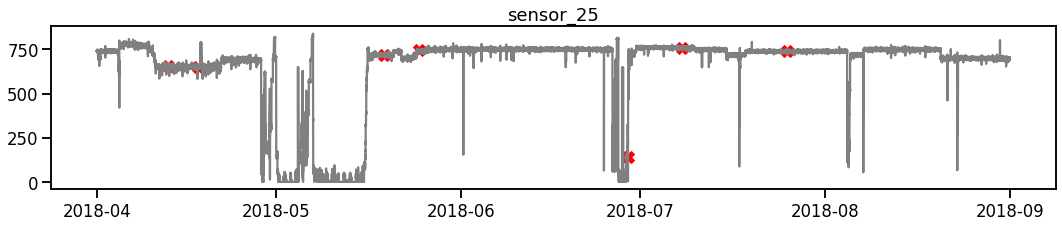

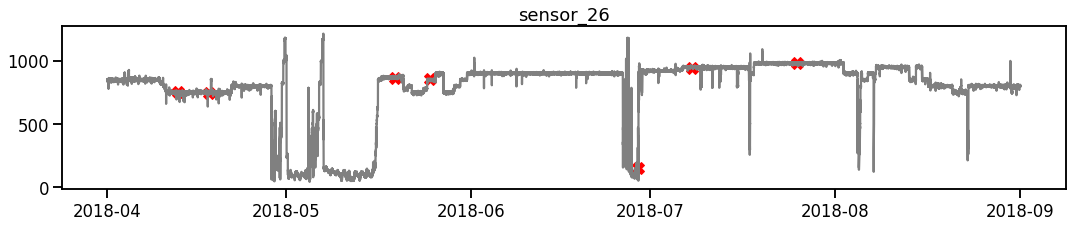

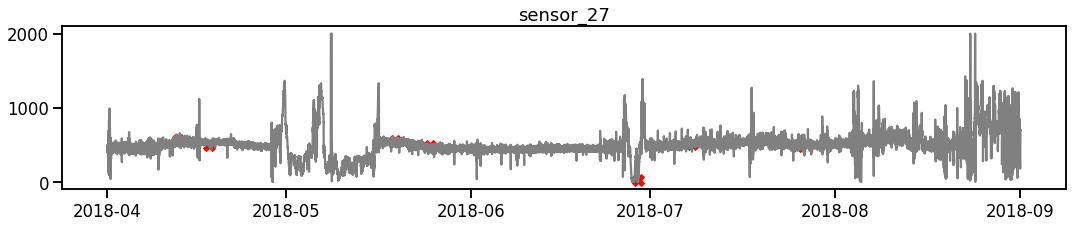

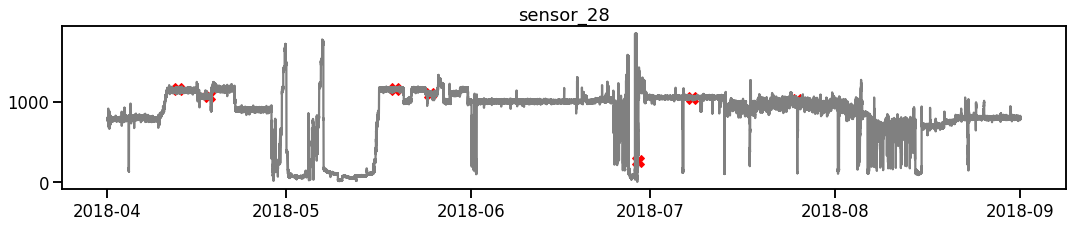

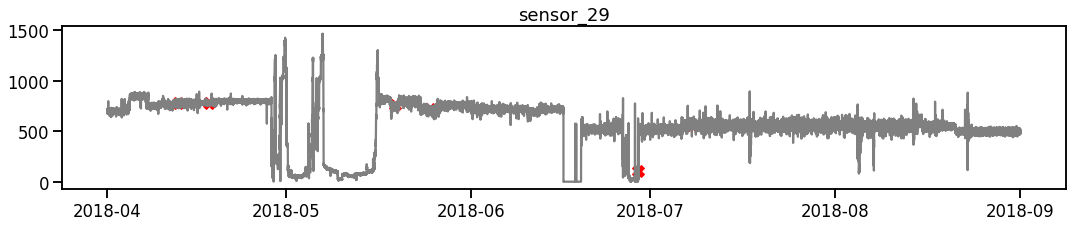

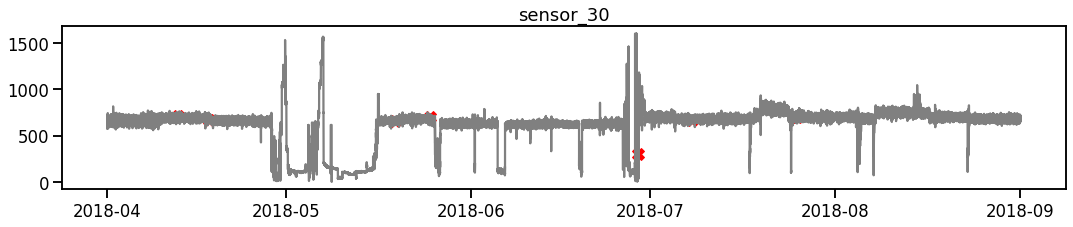

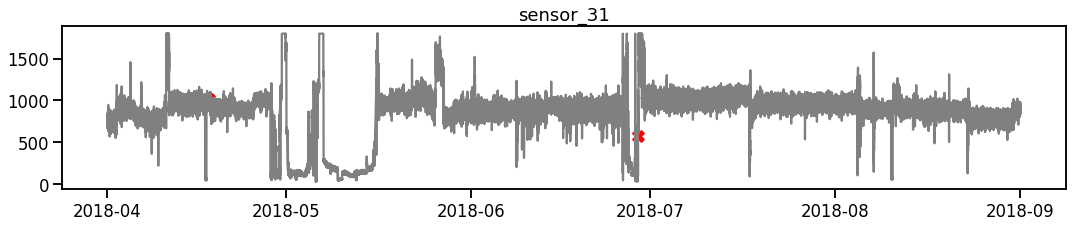

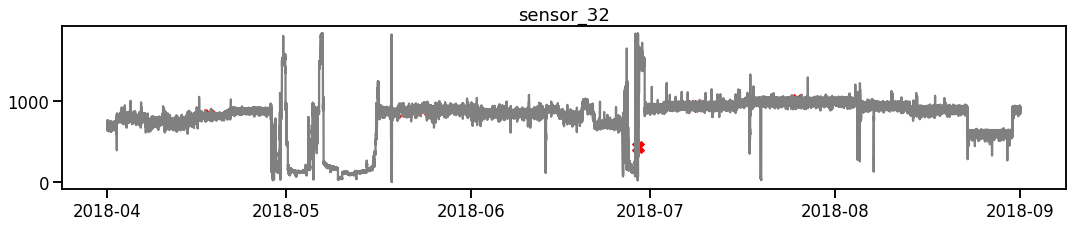

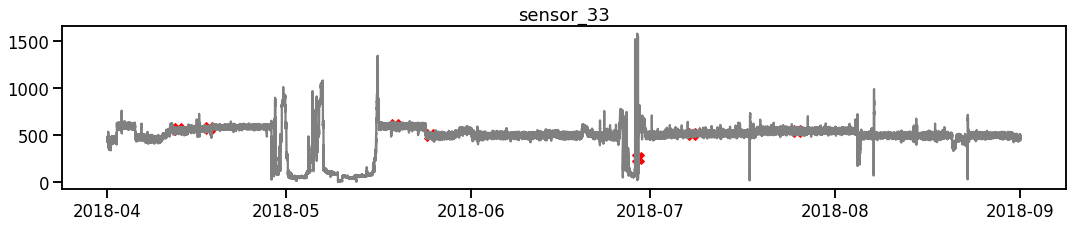

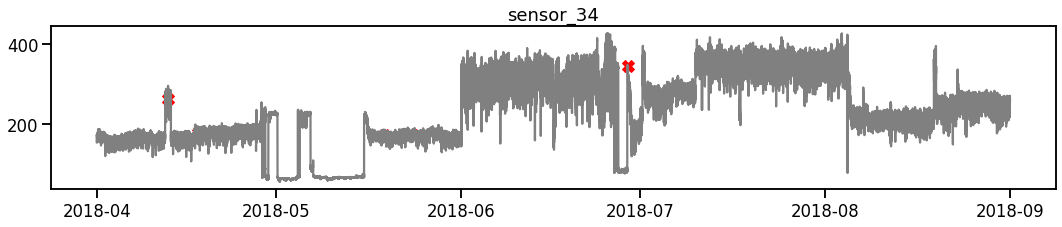

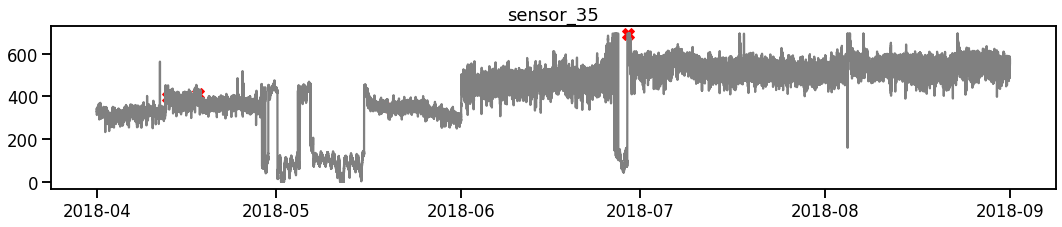

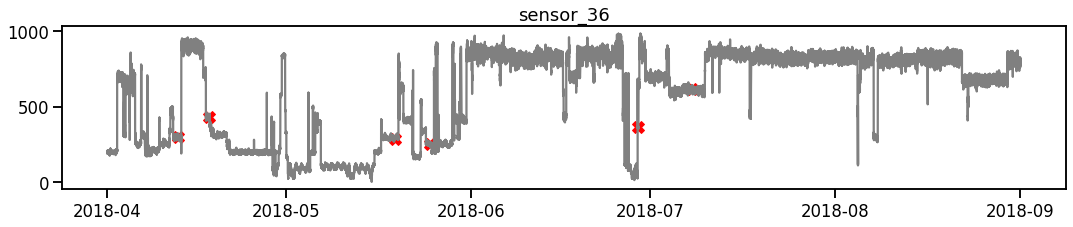

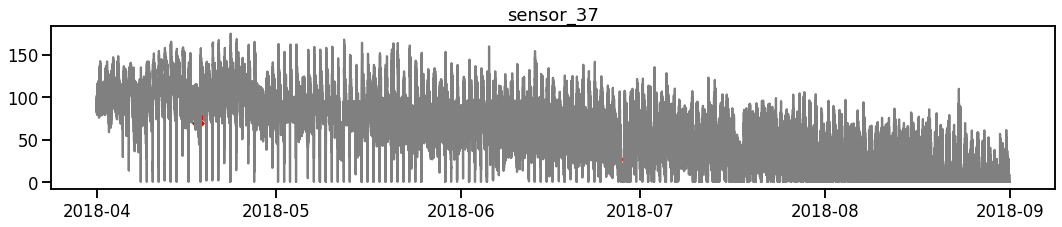

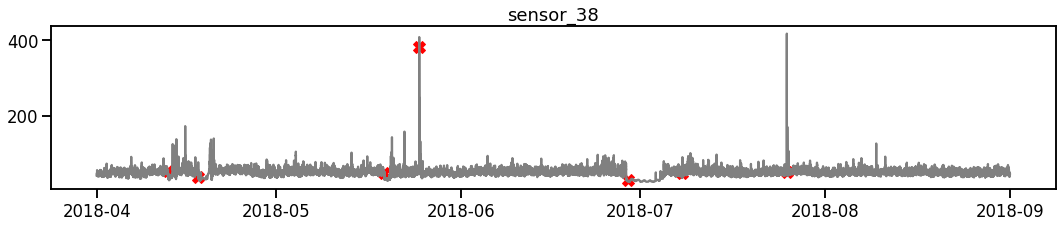

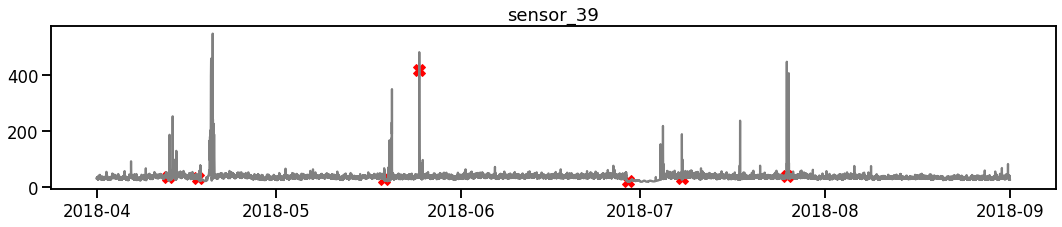

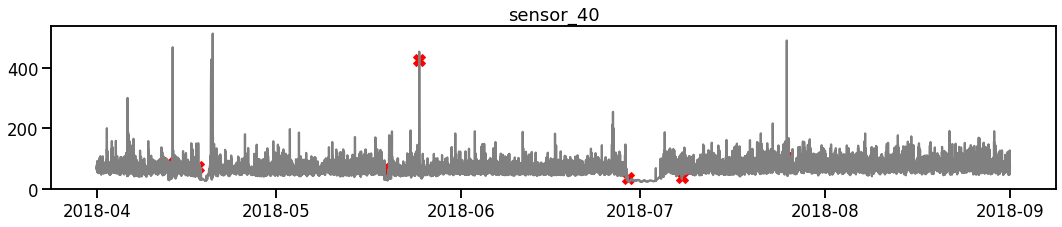

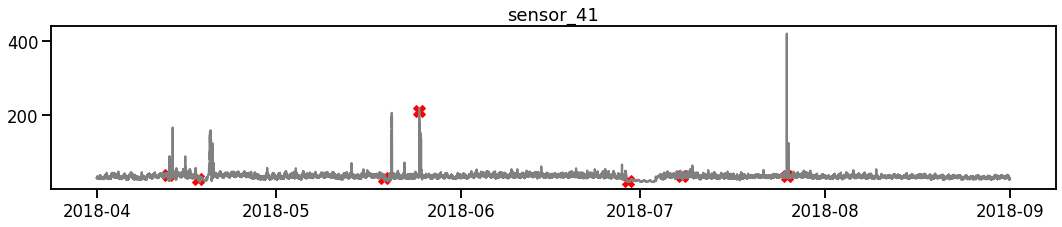

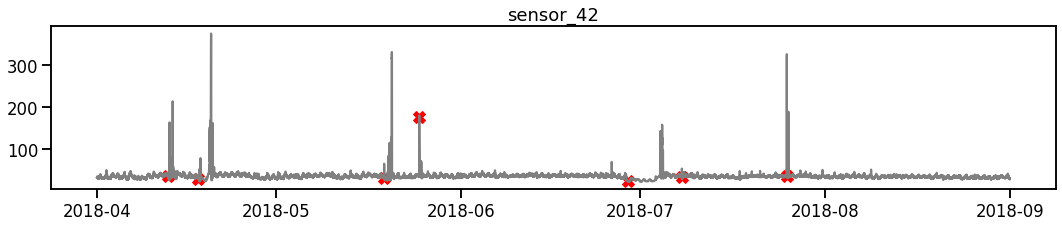

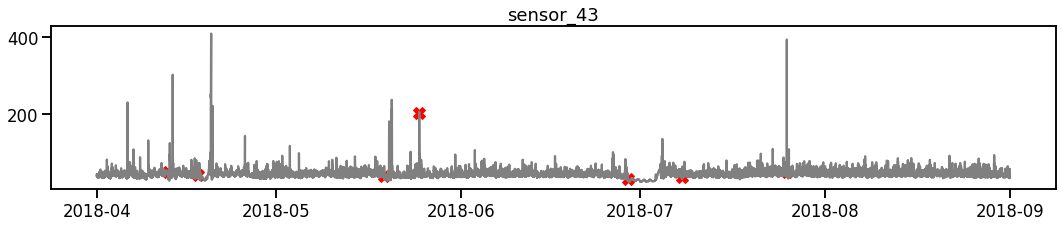

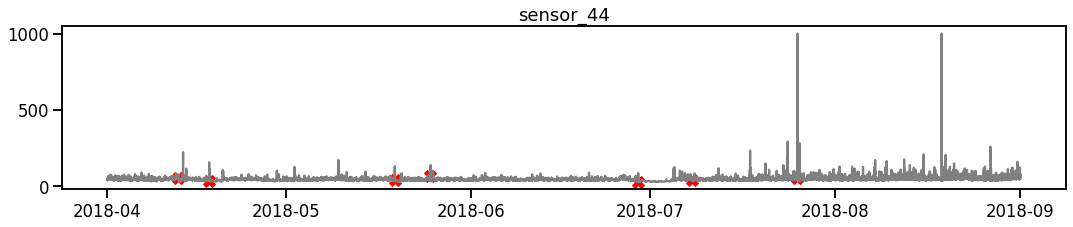

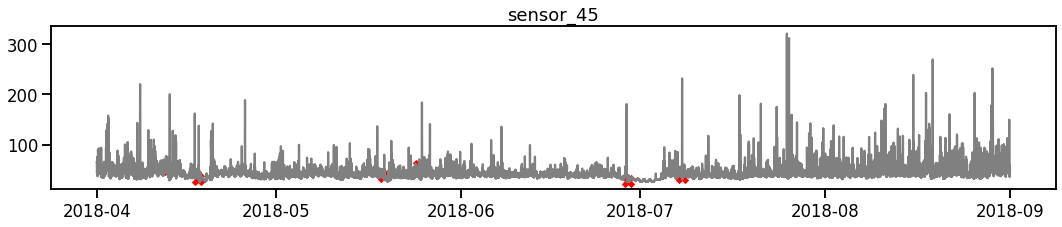

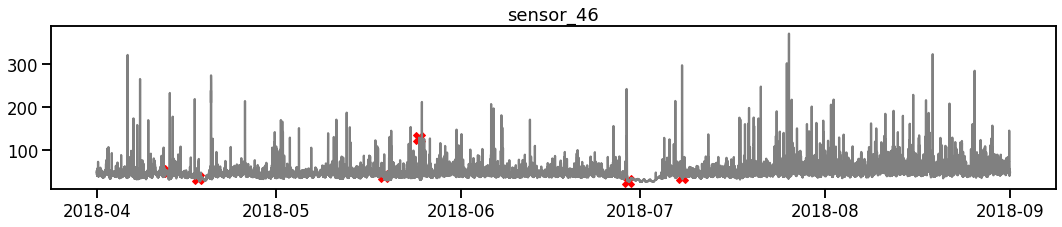

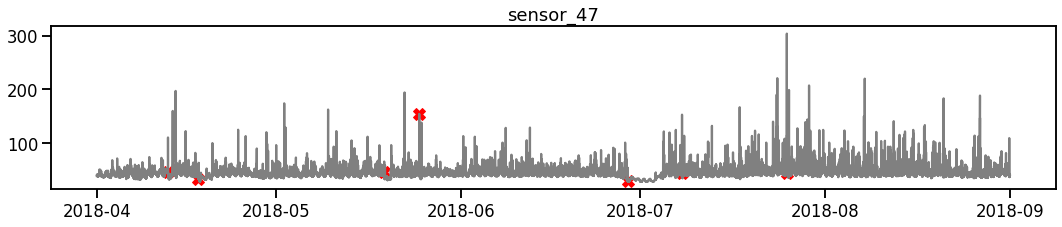

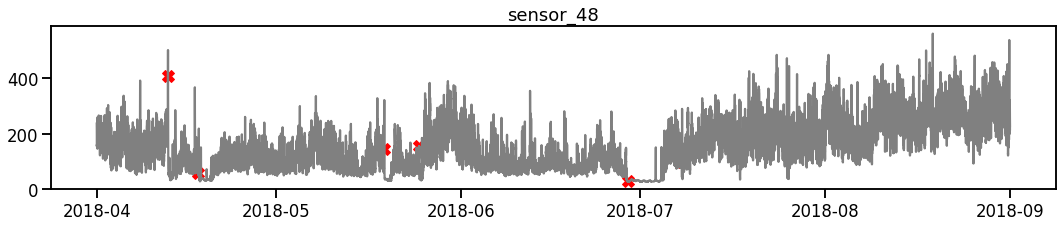

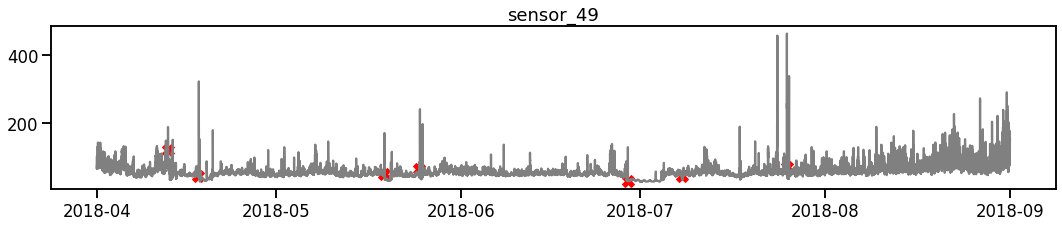

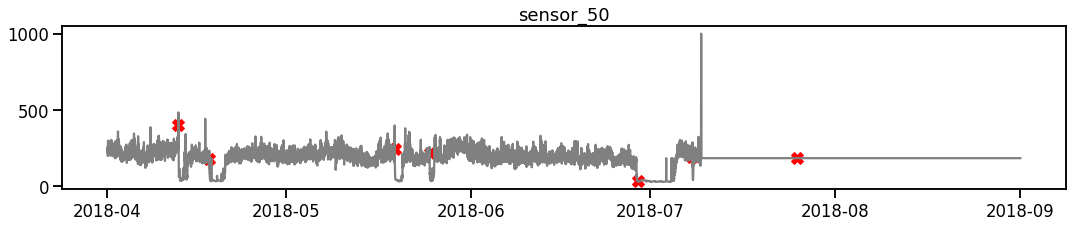

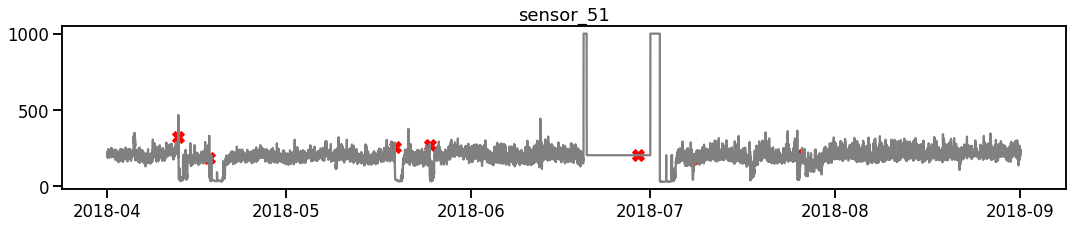

In [13]:
# Loop through sensors ploting their values and marking with an X, instances
# where machine status is "BROKEN"
dfBroken = df[df['machine_status']=='BROKEN']
dfSensors = df.drop(['machine_status'], axis=1)
sensorNames=dfSensors.columns
for sensor in sensorNames:
    sns.set_context('talk')
    _ = plt.figure(figsize=(18,3))
    _ = plt.plot(dfBroken[sensor], linestyle='none', marker='X', color='red', markersize=12)
    _ = plt.plot(df[sensor], color='grey')
    _ = plt.title(sensor)
    plt.show()

## 2.4.3 Dimensions reduction with PCA (Principal Component Analysis)

We use PCA to extract the most important features of our data, these will be used for model training, since processing the data with its current size is pretty resource demanding and nonoptimal.

PCA is a technique used to extract new features to be used for the modeling. For PCA to be applied, the data needs to be scaled and standarized.

- Scale the data
- Perform PCA and look at the most important principal components based on inertia.  

In [14]:
x = df[sensorNames]
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(x)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

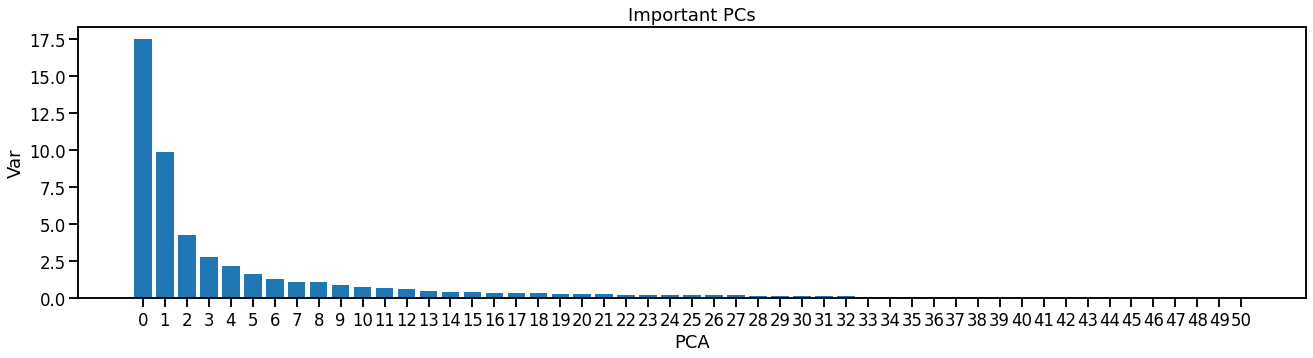

In [15]:
features = range(pca.n_components_)
_ = plt.figure(figsize=(22, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA')
_ = plt.ylabel('Var')
_ = plt.xticks(features)
_ = plt.title("Important PCs")
plt.show()

## 2.4.4 PCA Analysis

From the above plot, we can see that the 3 first components are the most impactful ones.

In [16]:
# So we will mainly use those three
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC0', 'PC1','PC2'])

In [17]:
df['PC0']=pd.Series(principalDf['PC0'].values, index=df.index)
df['PC1']=pd.Series(principalDf['PC1'].values, index=df.index)
df['PC2']=pd.Series(principalDf['PC2'].values, index=df.index)

# 2.5 Component check

Since our data is indexed with timestamps, it is key for our data to be stationary and have no autocorrelation for each of the three main components.

To be more specific, a pandas series is stationary if the mean of the values and the variability is constant throughout the timestamps. From that, we can obtain reliable predictions. Autocorrelation, refers to the presence or absense of correlation in timeseries data. Meaning, if past values affect the current values. For that, we must assure that our data is independent in time.

## 2.5.1 Stationary check

Check if PC1, PC2 y PC3 are stationary, using the *Augmented Dickey Fuller test (ADF Test)* technique.

To put it simple, this technique calculates the p-value, and if it is significantly lower than 0.05, we can consider the series as stationary.

In [18]:
from statsmodels.tsa.stattools import adfuller
# Augmented Dickey Fuller Test
for comp in ["PC0", "PC1", "PC2"]:
  result = adfuller(principalDf['PC0'])
  print(comp, result[1])

PC0 2.4667258834258273e-05
PC1 2.4667258834258273e-05
PC2 2.4667258834258273e-05


## 2.5.2 Check data autocorrelation

From the following plots for each component, we can verify that the values of each component are independent from each other and time.

PC0s autocorrelation:  -6.7691470705047994e-06
PC1s autocorrelation:  -1.4774567856262562e-06
PC2s autocorrelation:  -8.400871564459146e-08


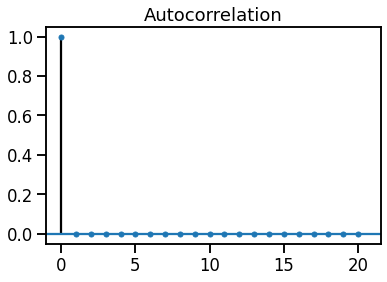

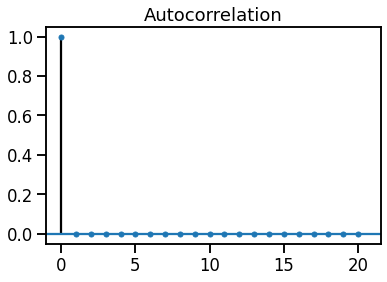

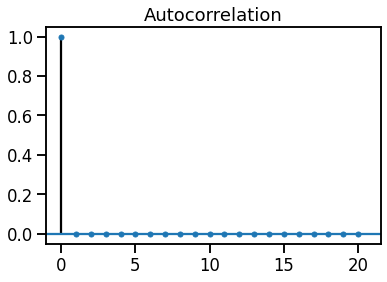

In [19]:
from statsmodels.graphics.tsaplots import plot_acf
for comp in ['PC0', 'PC1', 'PC2']:
  # Compute change in daily mean
  pca = principalDf[comp].pct_change()
  autocorrelation = pca.dropna().autocorr()
  print(f'{comp}s autocorrelation: ', autocorrelation)
  # Plot ACF
  plot_acf(pca.dropna(), lags=20, alpha=0.05)

# Technique 1: Interquartile range

In the descriptive statistics, interquertile range (IQR) is a statistical dispersion measure. Data is divided in 4 equal parts and the values that separate each part are called first (Q1), second (Q2) and third quartile (Q3).

The IQR is calculated from the difference between the percentiles 75 and 25, meaning **IQR = Q3 - Q1**.

For the anomaly detection case, the general rule is that the values considered as anomalies are usually in one of these ranges:

*   Bellow percentile 25 - 1,5 * IQR
*   Above percentile 75 + 1,5 * IQR

In [20]:
# So, we calculate the quartiles Q3 and Q1 for each component X. Then we calculate
# the IQR from its difference. Finally, we calculate the minimum (lower_pcX)
# and the maximum (upper_pcX) values in order to identify the anomaly values.

# PC0
q1_pc1, q3_pc1 = df['PC0'].quantile([0.25, 0.75])
iqr_pc1 = q3_pc1 - q1_pc1
lower_pc1 = q1_pc1 - (1.5*iqr_pc1)
upper_pc1 = q3_pc1 + (1.5*iqr_pc1)

# PC1
q1_pc2, q3_pc2 = df['PC1'].quantile([0.25, 0.75])
iqr_pc2 = q3_pc2 - q1_pc2
lower_pc2 = q1_pc2 - (1.5*iqr_pc2)
upper_pc2 = q3_pc2 + (1.5*iqr_pc2)

# PC2
q1_pc3, q3_pc3 = df['PC2'].quantile([0.25, 0.75])
iqr_pc3 = q3_pc3 - q1_pc3
lower_pc3 = q1_pc3 - (1.5*iqr_pc3)
upper_pc3 = q3_pc3 + (1.5*iqr_pc3)

print("PC0", lower_pc1, upper_pc1)
print("PC1", lower_pc2, upper_pc2)
print("PC2", lower_pc3, upper_pc3)

PC0 -740.9808649888971 222.78396607088993
PC1 -734.0274078396551 677.8571683061762
PC2 -315.67062674836427 296.91306706647504


In [29]:
# For each component PCi, we label as outliers (1), values that go out of range:
# values lower than "lower_pci" or higher than "upper_pci".

df['anomaly_pc1'] = ((df['PC0']>upper_pc1) | (df['PC0']<lower_pc1)).astype('int')
df['anomaly_pc2'] = ((df['PC1']>upper_pc2) | (df['PC1']<lower_pc2)).astype('int')
df['anomaly_pc3'] = ((df['PC2']>upper_pc3) | (df['PC2']<lower_pc3)).astype('int')

# Finally. we count the anomaly/outlier values (1) for each component.
total = len(df['anomaly_pc1'])

print("PC0:", (df['anomaly_pc1'].value_counts()[1]/total)*100, "%")
print("PC1:", (df['anomaly_pc2'].value_counts()[1]/total)*100, "%")
print("PC2:", (df['anomaly_pc3'].value_counts()[1]/total)*100, "%")

PC0: 13.693264342774148 %
PC1: 0.7371096586782862 %
PC2: 7.765068990559186 %


In [30]:
# Application of the SelectKBest model to get the features with the best score
# relative to the state of the machine, the components and the anomalies.

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
x = df.drop(['machine_status', 'PC0','PC1' ,'PC2', 'anomaly_pc1', 'anomaly_pc2', 'anomaly_pc3'], axis=1)
y = df['machine_status']
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
bestfeatures = SelectKBest(score_func=chi2, k=3)
fit = bestfeatures.fit(x_scaled, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Feature', 'Score']
print(featureScores.nlargest(3, 'Score'))

      Feature         Score
11  sensor_11  10123.423188
12  sensor_12   9893.118661
4   sensor_04   8183.512414


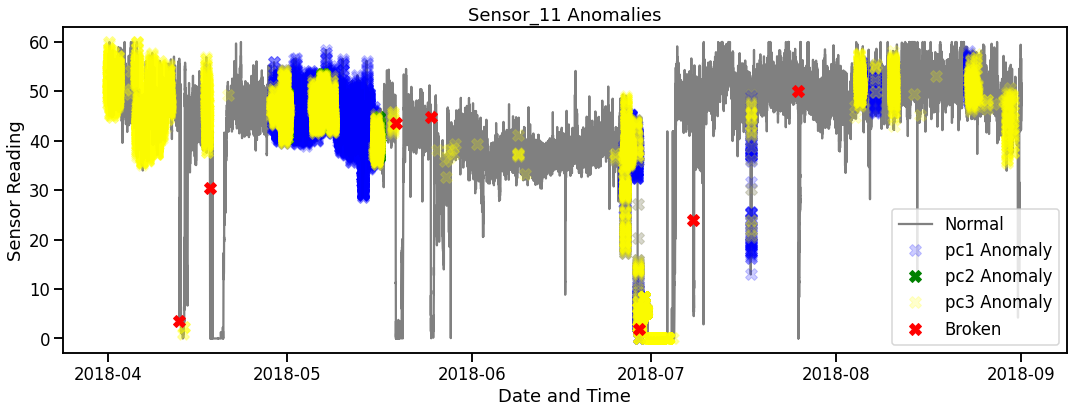

In [31]:
# Now, plot of the values from each sensor selected by the previous model, showing.
# the anomalies through time, leading to the machine being in the state: BROKEN.

a = df[df['anomaly_pc1'] == 1] #anomaly
b = df[df['anomaly_pc2'] == 1]
c = df[df['anomaly_pc3'] == 1]
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df['sensor_11'], color='grey', label='Normal')
_ = plt.plot(a['sensor_11'], linestyle='none', marker='X', color='blue', markersize=12, label='pc1 Anomaly', alpha = 0.2)
_ = plt.plot(b['sensor_11'], linestyle='none', marker='X', color='green', markersize=12, label='pc2 Anomaly')
_ = plt.plot(c['sensor_11'], linestyle='none', marker='X', color='yellow', markersize=12, label='pc3 Anomaly', alpha=0.2)
_ = plt.plot(dfBroken['sensor_11'], linestyle='none', marker='X', color='red', markersize=12, label='Broken')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor_11 Anomalies')
_ = plt.legend(loc='best')
plt.show();

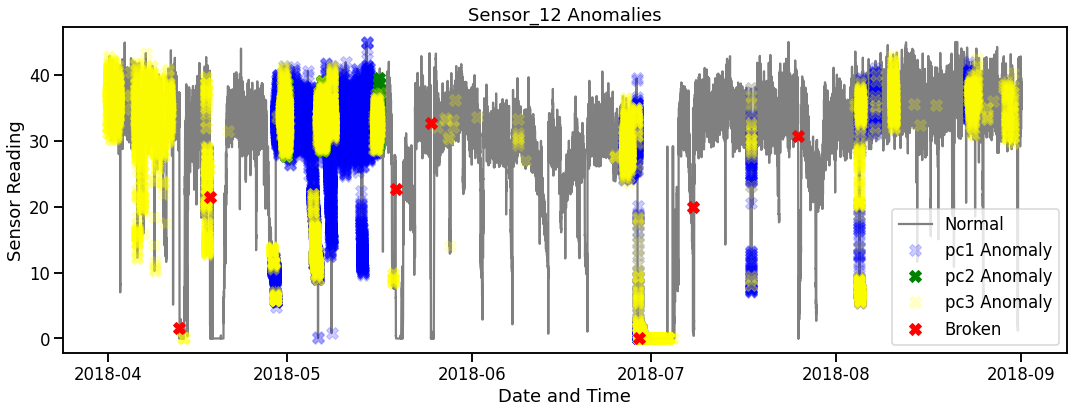

In [32]:
# Sensor_12
a = df[df['anomaly_pc1'] == 1] #anomaly
b = df[df['anomaly_pc2'] == 1]
c = df[df['anomaly_pc3'] == 1]
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df['sensor_12'], color='grey', label='Normal')
_ = plt.plot(a['sensor_12'], linestyle='none', marker='X', color='blue', markersize=12, label='pc1 Anomaly', alpha = 0.2)
_ = plt.plot(b['sensor_12'], linestyle='none', marker='X', color='green', markersize=12, label='pc2 Anomaly')
_ = plt.plot(c['sensor_12'], linestyle='none', marker='X', color='yellow', markersize=12, label='pc3 Anomaly', alpha=0.2)
_ = plt.plot(dfBroken['sensor_12'], linestyle='none', marker='X', color='red', markersize=12, label='Broken')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor_12 Anomalies')
_ = plt.legend(loc='best')
plt.show();

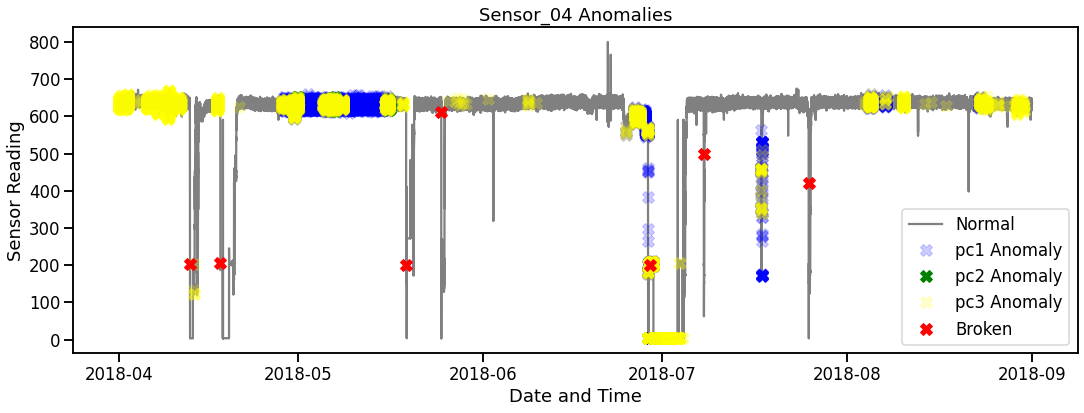

In [34]:
# Sensor_04
a = df[df['anomaly_pc1'] == 1] #anomaly
b = df[df['anomaly_pc2'] == 1]
c = df[df['anomaly_pc3'] == 1]
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df['sensor_04'], color='grey', label='Normal')
_ = plt.plot(a['sensor_04'], linestyle='none', marker='X', color='blue', markersize=12, label='pc1 Anomaly', alpha = 0.2)
_ = plt.plot(b['sensor_04'], linestyle='none', marker='X', color='green', markersize=12, label='pc2 Anomaly')
_ = plt.plot(c['sensor_04'], linestyle='none', marker='X', color='yellow', markersize=12, label='pc3 Anomaly', alpha=0.2)
_ = plt.plot(dfBroken['sensor_04'], linestyle='none', marker='X', color='red', markersize=12, label='Broken')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor_04 Anomalies')
_ = plt.legend(loc='best')
plt.show();

# Técnica 2: K-Means Clustering

K-means is an unsupervised classification algorithm that groups(clustering) instances in k groups based on their features. The clustering is done by maximizing the sum of the distances between each instance and its cluster's centroid. It usually uses the quadratic distance. 

This algorithm solves an optimization problem, being the function to optimize (minimize) the sum of the quadratic distances of each instance to the centroid of its cluster. In our particular case, the biggest distances are considered as anomalies. The result is manifested as 0 for normal and 1 for anomaly for each analized component.

In [36]:
# Initialize the K-means algorithm with 3 clusters one for each machine state.
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(principalDf.values)
labels = kmeans.predict(principalDf.values)
unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))
clusters

array([[     0,      1,      2],
       [141644,  23612,  55064]])

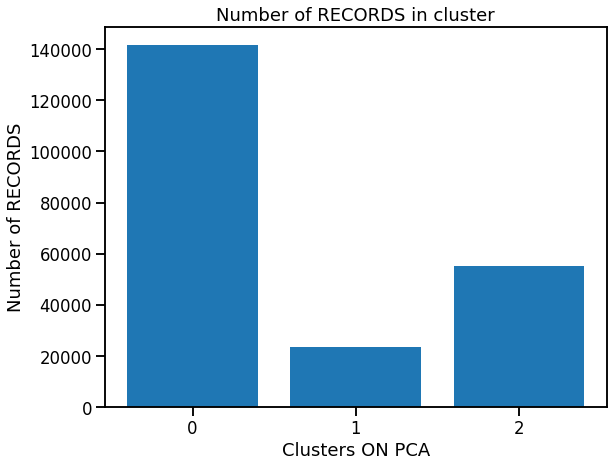

In [37]:
# Plot the number of instances for each cluster/machine state.
# Cluster 0 = "Recovering"
# Cluster 1 = "Broken"
# Cluster 3 = "Normal"
_ = plt.figure(figsize = (9, 7))
_ = plt.bar(clusters[0], clusters[1], tick_label=clusters[0])
_ = plt.xlabel('Clusters ON PCA')
_ = plt.ylabel('Number of RECORDS')
_ = plt.title('Number of RECORDS in cluster')
plt.show()

In [38]:
principalDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PC0     220320 non-null  float64
 1   PC1     220320 non-null  float64
 2   PC2     220320 non-null  float64
dtypes: float64(3)
memory usage: 5.0 MB


In [39]:
principalDf.head()

,PC0,PC1,PC2
0,69.942182,265.865297,-429.093873
1,69.942182,265.865297,-429.093873
2,28.250111,283.621565,-400.744476
3,24.950602,290.367435,-370.356271
4,30.041143,294.778305,-390.633054


# Clusters visualizacion

Firstly, we plot comparisons in 2D between 2 components, as follows:

- PC0 vs PC1
- PC1 vs PC2
- PC0 vs PC2

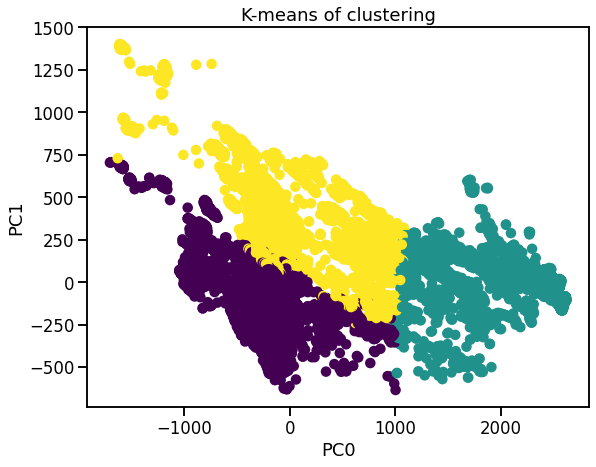

In [ ]:
_ = plt.figure(figsize=(9,7))
_ = plt.scatter(principalDf['PC0'], principalDf['PC1'], c=labels)
_ = plt.xlabel('PC0')
_ = plt.ylabel('PC1')
_ = plt.title('K-means of clustering')
plt.show()

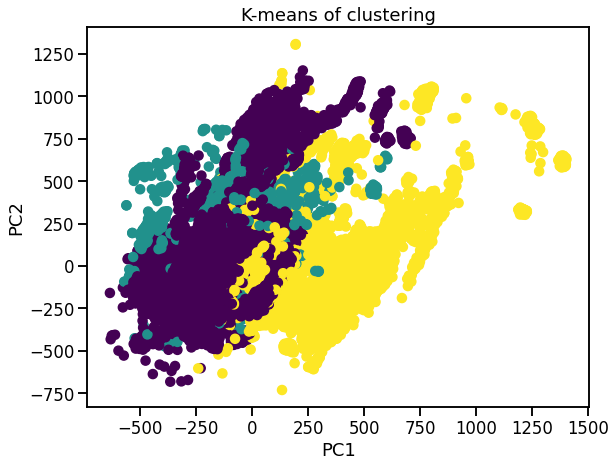

In [ ]:
_ = plt.figure(figsize=(9,7))
_ = plt.scatter(principalDf['PC1'], principalDf['PC2'], c=labels)
_ = plt.xlabel('PC1')
_ = plt.ylabel('PC2')
_ = plt.title('K-means of clustering')
plt.show()

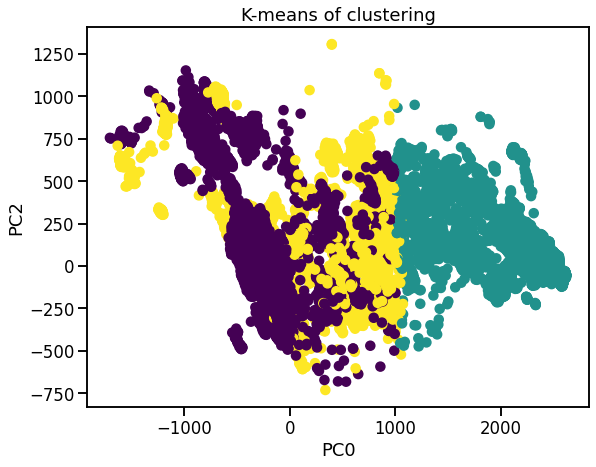

In [ ]:
_ = plt.figure(figsize=(9,7))
_ = plt.scatter(principalDf['PC0'], principalDf['PC2'], c=labels)
_ = plt.xlabel('PC0')
_ = plt.ylabel('PC2')
_ = plt.title('K-means of clustering')
plt.show()

In [40]:
from mpl_toolkits import mplot3d

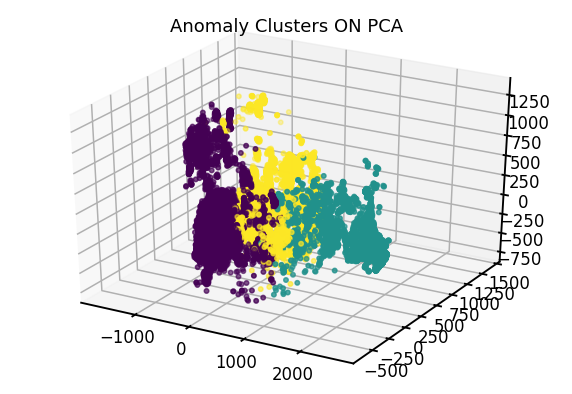

In [41]:
# Now, lets plot a 3D graphic, comparing all three components
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
ax.scatter3D(principalDf['PC0'], principalDf['PC1'], principalDf['PC2'], c=labels)
plt.title("Anomaly Clusters ON PCA")
 
# show plot
plt.show()

In [42]:
# Function to measure the distance between each instance and the
# closest cluster centroid.

def getDistanceByPoint(data, model):
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)

In [43]:
# Fraction of values considered as anomalies
outliers_fraction = 0.13
# Obtaining the distances, the biggest ones are considered as anomalies.
distance = getDistanceByPoint(principalDf, kmeans)
# Number of instances that are the 13% of data
number_of_outliers = int(outliers_fraction*len(distance))
# As a threshold, the minimum value of the largest distances from the 13%.
threshold = distance.nlargest(number_of_outliers).min()

principalDf['anomaly1'] = (distance >= threshold).astype(int)

In [44]:
principalDf.head()

,PC0,PC1,PC2,anomaly1
0,69.942182,265.865297,-429.093873,1
1,69.942182,265.865297,-429.093873,1
2,28.250111,283.621565,-400.744476,1
3,24.950602,290.367435,-370.356271,1
4,30.041143,294.778305,-390.633054,1


In [45]:
# Value count where normal: 0 and anomaly: 1 ("Broken" and "Recovering")
principalDf['anomaly1'].value_counts()

0    191679
1     28641
Name: anomaly1, dtype: int64

In [46]:
dfBroken = df[df['machine_status']=='BROKEN']
dfReco = df[df['machine_status']=='RECOVERING']

# Time plots vs each important sensor showing where anomalies occured.


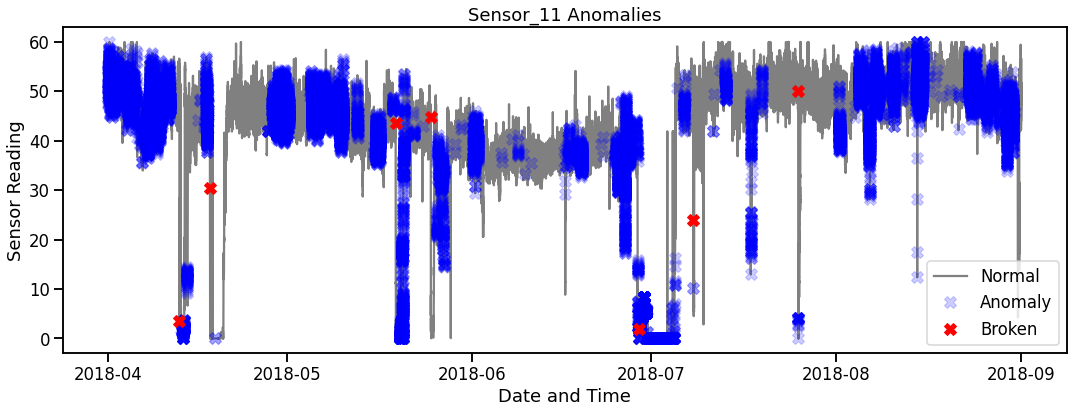

In [47]:
df['anomaly1'] = pd.Series(principalDf['anomaly1'].values, index=df.index)
a = df[df['anomaly1'] == 1] #Anomalía
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df['sensor_11'], color='grey', label='Normal')
_ = plt.plot(a['sensor_11'],linestyle='none', marker='X', color='blue', markersize=12, label='Anomaly', alpha= 0.2)
_ = plt.plot(dfBroken['sensor_11'], linestyle='none', marker='X', color='red', markersize=12, label='Broken')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor_11 Anomalies')
_ = plt.legend(loc='best')
plt.show();

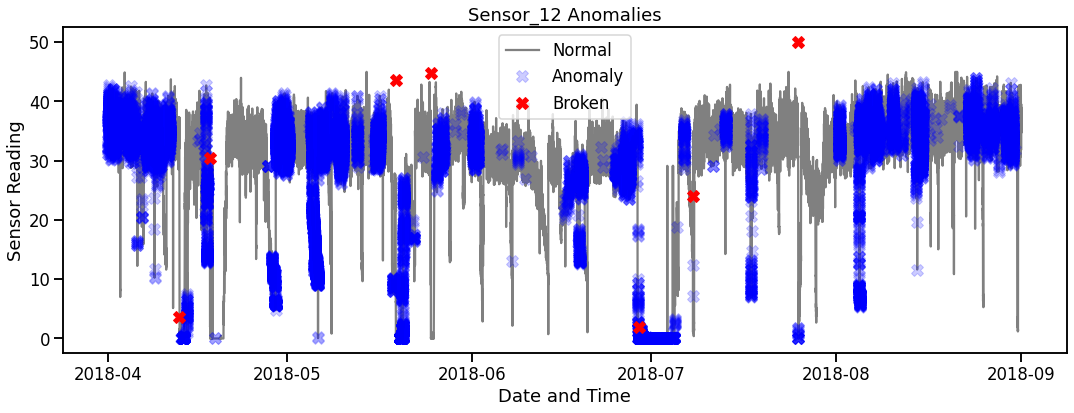

In [ ]:
df['anomaly1'] = pd.Series(principalDf['anomaly1'].values, index=df.index)
a = df[df['anomaly1'] == 1] #Anomalía
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df['sensor_12'], color='grey', label='Normal')
_ = plt.plot(a['sensor_12'],linestyle='none', marker='X', color='blue', markersize=12, label='Anomaly', alpha= 0.2)
_ = plt.plot(dfBroken['sensor_11'], linestyle='none', marker='X', color='red', markersize=12, label='Broken')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor_12 Anomalies')
_ = plt.legend(loc='best')
plt.show();

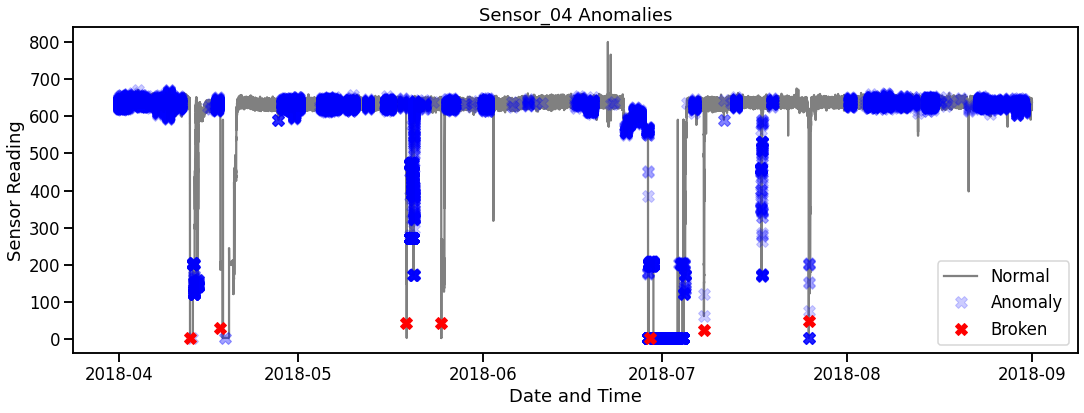

In [ ]:
df['anomaly1'] = pd.Series(principalDf['anomaly1'].values, index=df.index)
a = df[df['anomaly1'] == 1] #Anomalía
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df['sensor_04'], color='grey', label='Normal')
_ = plt.plot(a['sensor_04'],linestyle='none', marker='X', color='blue', markersize=12, label='Anomaly', alpha= 0.2)
_ = plt.plot(dfBroken['sensor_11'], linestyle='none', marker='X', color='red', markersize=12, label='Broken')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor_04 Anomalies')
_ = plt.legend(loc='best')
plt.show();

From these plots, we can clearly see that this method ignores several anomalies. For instance, from the 7 "BROKEN" anomalies, only 1 is detected as we can see in the following cells:

In [48]:
df[df['anomaly1']==1]['machine_status'].value_counts()

NORMAL        25813
RECOVERING     2827
BROKEN            1
Name: machine_status, dtype: int64

In [49]:
df['machine_status'].value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

# Técnica 3: Isolation Forest

Isolation Forest is an unsupervised algorithm that is particularly good for anomaly detection(outliers). It is inspired in the regression and classification algorithm called Random Forest. It combines multiple tree structures called isolation trees. These are created in a similar way as the ones from classification-regression: the training instances are recursively broken down, creating the branches until each instance is isolated. The difference is that this algorithm does the division (where instances are broken down) randomly. So, those instances that have different features (from the most) will be isolated in few divisions. Thus, the number of nodes necessary to get to these instances from the root is less than the others (Anomaly).

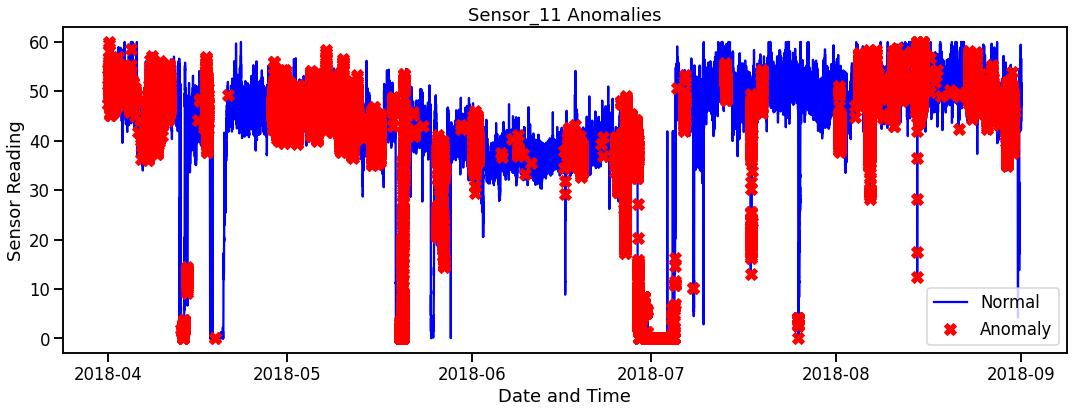

In [ ]:
# Import IsolationForest
from sklearn.ensemble import IsolationForest
# Assume that 13% of the entire data set are anomalies
 
outliers_fraction = 0.13
model =  IsolationForest(contamination=outliers_fraction)
model.fit(principalDf.values) 
principalDf['anomaly2'] = pd.Series(model.predict(principalDf.values))
# visualization
df['anomaly2'] = pd.Series(principalDf['anomaly2'].values, index=df.index)
a = df.loc[df['anomaly2'] == -1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df['sensor_11'], color='blue', label='Normal')
_ = plt.plot(a['sensor_11'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor_11 Anomalies')
_ = plt.legend(loc='best')
plt.show();

# Conclusions

As we can see, the three algorithms show graphic representations that make it easy to spot the anomalies from the data distribution. We can also see that the results are coherent between the different approaches since all of them return as the most representative sensors (relative to anomalies): sensor 11, sensor 12 and sensor 4. Finally, data cleaning and pre-processing was incredibly usefull using PCA to help decrease the number of dimensions for our problem. Also, the approaches were coherent thanks to the checks of the data being stationary and independent from previous values and time.